In [1]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.LEDNet.models import lednet
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing
import torchsummary
from models.config import *

/Users/francescobaraldi/opt/anaconda3/envs/cv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# configuration
n_examples = 5
model_name = 'lednet_ccncsa'
weights_path = "models/weights/"
dataset_path = ROOT_DIR + "headsegmentation_dataset_ccncsa/"

In [4]:
# defining transforms
tH, tW = 256, 256
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # from ImageNet
image_transform = T.Compose([T.Resize((tH, tW)), T.Normalize(mean, std)])
target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, 'training.xml')
X_train, X_test, Y_train, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.MyDataset(X_train, Y_train, image_transform, target_transform)
test_dataset = dataset.MyDataset(X_test, Y_test, image_transform, target_transform)

In [5]:
# training hyperparameters
device = 'cpu'
batch_size = 32
n_epochs = 50

# model, loss, score function
model = lednet.LEDNet(num_classes=n_classes, output_size=(tH, tW))
loss_fn = nn.CrossEntropyLoss()
score_fn = metrics.batch_mIoU

# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# printing model summary
torchsummary.summary(model=model, input_size=(3, tH, tW), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1          [32, 3, 128, 128]               0
            Conv2d-2         [32, 29, 128, 128]             812
       BatchNorm2d-3         [32, 32, 128, 128]              64
              ReLU-4         [32, 32, 128, 128]               0
  DownsamplerBlock-5         [32, 32, 128, 128]               0
            Conv2d-6         [32, 16, 128, 128]             784
              ReLU-7         [32, 16, 128, 128]               0
            Conv2d-8         [32, 16, 128, 128]             784
       BatchNorm2d-9         [32, 16, 128, 128]              32
             ReLU-10         [32, 16, 128, 128]               0
           Conv2d-11         [32, 16, 128, 128]             784
             ReLU-12         [32, 16, 128, 128]               0
           Conv2d-13         [32, 16, 128, 128]             784
      BatchNorm2d-14         [32, 16, 1

In [7]:
# training
results = training_and_testing.train_model(
    device, model, test_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, lr_scheduler=None, evaluate=True, verbose=True)

Device: cpu.
--- Epoch 1/50 ---
average_train_loss: 1.2366667499487427, average_train_score: 0.3204895555973053
average_val_loss: 0.8590723723173141, average_val_score: 0.3594164550304413
--- Epoch 2/50 ---
average_train_loss: 0.6789413786482537, average_train_score: 0.37297847867012024
average_val_loss: 0.5809650868177414, average_val_score: 0.3895222842693329
--- Epoch 3/50 ---
average_train_loss: 0.5792185948497948, average_train_score: 0.38377314805984497
average_val_loss: 0.6388318724930286, average_val_score: 0.3734949827194214
--- Epoch 4/50 ---
average_train_loss: 0.5418638648657963, average_train_score: 0.38839834928512573
average_val_loss: 0.6193780042231083, average_val_score: 0.3801735043525696
--- Epoch 5/50 ---
average_train_loss: 0.49772488968125705, average_train_score: 0.39778605103492737
average_val_loss: 0.4532705210149288, average_val_score: 0.4076268970966339
--- Epoch 6/50 ---
average_train_loss: 0.4754013175936951, average_train_score: 0.4041346311569214
average_

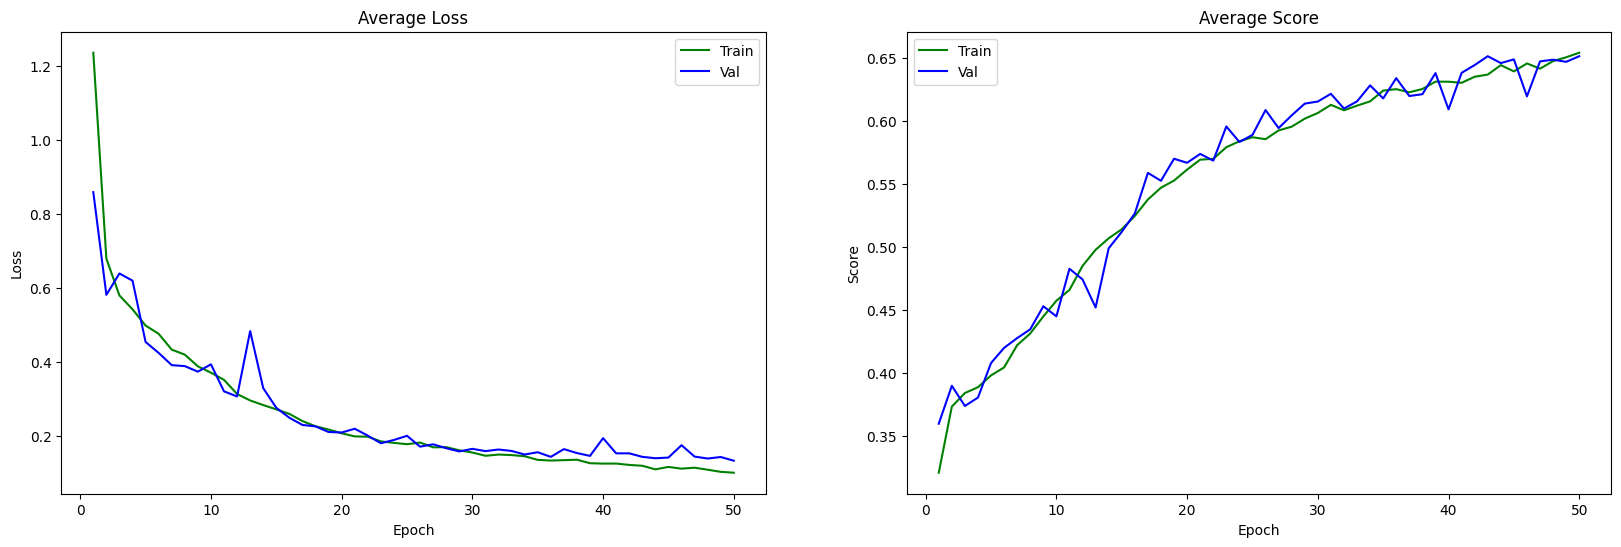

In [4]:
# plotting training results
training_and_testing.plot_training_results(results, plotsize=(20, 6))

In [ ]:
# resetting model, optimizer, learning rate scheduler
final_model = lednet.LEDNet(num_classes=n_classes)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate)

# re-training model on entire training set and saving its weights
final_n_epochs = 25
training_and_testing.train_model(
    device, final_model, train_dataset, batch_size, final_n_epochs, score_fn, loss_fn, final_optimizer, verbose=True)
torch.save(final_model.state_dict(), weights_path + model_name + '.pth')

In [ ]:
# loading pretrained final model
try:
    final_model
except:
    final_model = lednet.LEDNet(num_classes=n_classes)
    final_model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
test_score_fn = metrics.batch_IoU
label_names = list(segmentation_labels.labels.keys())
batch_IoU = training_and_testing.test_model(device, final_model, test_dataset, batch_size, test_score_fn)
batch_IoU_with_labels = { label: score for label, score in list(zip(label_names, batch_IoU.tolist())) }
batch_mIoU = batch_IoU.mean().item()
for label in batch_IoU_with_labels:
    print(f'batch_IoU_{label}: {batch_IoU_with_labels[label]}')
print(f'batch_mIoU={batch_mIoU}')

In [ ]:
# plotting some random examples from test dataset
random_images = torch.zeros((n_examples, 3, tH, tW))
random_targets = torch.zeros((n_examples, n_classes, tH, tW))
for i in range(n_examples):
    random_idx = torch.randint(high=len(test_dataset), size=(1,))
    random_image, random_target = test_dataset[random_idx]
    random_images[i] = random_image
    random_targets[i] = random_target
with torch.no_grad():
    final_model.eval()
    random_output = final_model(random_images)[0]
channels_max, _ = torch.max(random_output, axis=1)
random_predictions = (random_output == channels_max.unsqueeze(axis=1))
for i in range(n_examples):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Ground Truth')
    plt.imshow(utils.from_DHW_to_HWD(color_processing.colorize_segmentation_masks(random_targets[i], segmentation_labels.labels)))
    plt.subplot(1, 2, 2)
    plt.title('Prediction')
    plt.imshow(utils.from_DHW_to_HWD(color_processing.colorize_segmentation_masks(random_predictions[i], segmentation_labels.labels)))